In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import rand,randint

# Class Memetic Algorithm:
i write a class (called Ma) that include all function i need to solve this problem
this class has some attribue that is describe below:
1. nQ : equal number of queen in the problem
2. popSize: equal size of population we want to solve the problem with that
3. maxGen: equal max number of generation we want to create even we don't receive our goal
4. pCross: equal probability of do crossover on 2 pair parents
5. pMut: equal probability of do mutation on a child
6. maxLocalSearch: equal max number of LocalSearch for an specific child in Local Search Algorithm
7. tSize: equal tabu size in my Local Search Algorithm
i have to mention we know the answer is a permutation so we allways create a permutation not anything array
actually index i in a specific permutation is row of queen in column i

# Fitness
actually i use negetive number of Threat in specific permutation equal to fitness of that.
so in a permutation two queen is a problem if they are in a same column or row or diameter
we can prove that this equal to abs(column[queen a]-column[queen b])==abs(row[queen a]-row[queen b])

# Create First Generation
it is obvious we use np.random.shuffle to create a random permutation
so we use this for popSize time to create First Generation of the algorithm
after that we produce fitnesses for this generation

# Rank Bases Selection
we use this algorithm to select all pair parents we want to recombine to create next generation(chilren)

# Crossover
actually for crossover for a pair parent i use ordered recombination algorithm and it has a probability of crossover that we set in first class

# Mutation
for mutation of a child i use ScrambleMutation to produce different child and also it has a probability of mutation that we set in first class

# Local Search Algorithm
i have to notice i user Tabu search for local search algorithm and two permutation are neighborhood if thay are different only in two index . we use tabu list to do less same work in low duration

In [9]:
class Ma():
    def __init__(self,nQ,popSize,maxGen,pCross,pMut,maxLocalSearch,pLocalSearch,tSize):
        self.nQ=nQ
        self.popSize=popSize
        self.maxGen=maxGen
        self.pCross=pCross
        self.pMut=pMut
        self.maxLocalSearch=maxLocalSearch
        self.pLocalSearch=pLocalSearch
        self.tSize=tSize
    def CalcFit(self,perm):
        fit=0
        for x in range(self.nQ):
            for y in range(x):
                if abs(perm[x]-perm[y])==abs(x-y):
                    fit-=1
        return fit
    def CalcThisAllFit(self,perms):
        return np.array([self.CalcFit(x) for x in self.population])
    def CalcAllFit(self):
        self.fitness=self.CalcThisAllFit(self.population)
    def CreateRandomPerm(self):
        perm=np.arange(self.nQ)
        np.random.shuffle(perm)
        return perm
    def SortThisPopWithFit(self,pop,fit):
        fitInd=fit.argsort()
        return [pop[fitInd[::-1]],fit[fitInd[::-1]]]
    def SortPopWithFit(self):
        self.population,self.fitness=self.SortThisPopWithFit(self.population,self.fitness)
    def CreateFirstGeneration(self):
        self.population=np.array([self.CreateRandomPerm() for _ in range(self.popSize)],dtype=np.int64)
        self.CalcAllFit()
        self.SortPopWithFit()
    def RankBasedSelection(self):
        rankFit=np.zeros(self.popSize)
        rankFit[0]=self.popSize
        sRank=self.popSize
        for i in range(1,self.popSize):
            if self.fitness[i]<self.fitness[i-1]:
                rankFit[i]=rankFit[i-1]-1
            else:
                rankFit[i]=rankFit[i-1]
            sRank+=rankFit[i]
        rankFit=np.array([x/sRank for x in rankFit])
        return self.population[np.random.choice(self.population.shape[0],self.popSize,p=rankFit)]
    def GetXYRandom(self):
        x,y=randint(0,self.nQ,2)
        y+=1
        while y==x:
            y=randint(0,self.nQ)
        if y<x:
            x,y=y,x
        return (x,y)
    def HelpCrossover(self,parent2,child,x,y):
        child[0:x]=-1
        child[y:self.nQ]=-1
        if y==self.nQ:
            y=0
        d=y
        while d!=x:
            if parent2[y] not in child:
                child[d]=parent2[y]
                d+=1
                if d==self.nQ:
                    d=0
            y+=1
            if y==self.nQ:
                y=0
        if -1 in child:
            display("ah",x,y,pd.DataFrame(child))
    def Crossover(self,parent1,parent2):
        child1=parent1.copy()
        child2=parent2.copy()
        if rand() < self.pCross:
            x,y=self.GetXYRandom()
            self.HelpCrossover(parent2,child1,x,y)
            self.HelpCrossover(parent1,child2,x,y)
        return [child1,child2]
    def ScrambleMutation(self,child):
        if rand()< self.pMut :
            x,y=self.GetXYRandom()
            np.random.shuffle(child[x:y])
    def ShiftArray(self,tabu,x):
        np.roll(x,1)
        tabu[0]=x
    def TabuSearch(self,perm,fit):
        best=perm
        bestF=fit
        tabu=np.empty((self.tSize,2),dtype=np.int64)
        tabu.fill(-1)
        for _ in range(self.maxLocalSearch):
            cand=best.copy()
            while True:
                x,y=self.GetXYRandom()
                y-=1
                if y!=x:
                    if [x,y] not in tabu:
                        break
            cand[x],cand[y]=cand[y],cand[x]
            self.ShiftArray(tabu,[x,y])
            candF=self.CalcFit(cand)
            if candF>=bestF:
                best=cand
                bestF=candF
        return (best,bestF)
    def CreateChildren(self):
        selected=self.RankBasedSelection()
        children=np.empty((self.popSize,self.nQ),dtype=np.int64)
        k=0
        for a, b in zip(selected[::2], selected[1::2]):
            children[k],children[k+1]=self.Crossover(a,b)
            for j in range(2):
                self.ScrambleMutation(children[k+j])
            k+=2
        fitChildren=self.CalcThisAllFit(children)
        for x in range(self.popSize):
             if rand()<self.pLocalSearch:
                children[x],fitChildren[x]=self.TabuSearch(children[x],fitChildren[x])
        children,fitChildren=self.SortThisPopWithFit(children,fitChildren)
        return [children,fitChildren]
    def GoNextGeneration(self):
        children,fitChildren=self.CreateChildren()
        if self.best[1]<=fitChildren[0]:
            self.best=[children[0],fitChildren[0]]
        else:
            self.ShiftArray(children,self.best[0])
            self.ShiftArray(fitChildren,self.best[1])
        self.population=children
        self.fitness=fitChildren
    def CreatePlot(self):
        self.fig=plt.figure()
        self.fd=self.fig.add_subplot()
        plt.title("Red = Best     Blue = Average")
        plt.xlabel("Generation")
        plt.ylabel("Fitness")
        self.bests=np.array([self.best[1]])
        self.means=np.array([self.fitness.mean()])
    def VisualPlot(self,g):
        self.bests=np.append(self.bests,self.best[1])
        self.means=np.append(self.means,self.fitness.mean())
        self.fd.plot(self.bests,color='r')
        self.fd.plot(self.means,color='b')
        self.fig.canvas.draw()
        self.fd.set_xlim(left=max(0,g-self.maxGen),right=g+3)
    def MemeticAlgorithm(self):
        self.CreateFirstGeneration()
        display(pd.DataFrame(self.population))
        self.best=[self.population[0],self.fitness[0]]
        display(pd.DataFrame(self.fitness))
        self.CreatePlot()
        print(self.best[1],self.means[-1])
        for gen in range(self.maxGen):
            self.GoNextGeneration()
            self.VisualPlot(gen)
            if self.best[1]==0:
                print("end in earlier:",gen)
                break
            if gen%50==0:
                print(self.best[1],self.means[-1])
        print('------------------------------')
        print(self.best[1])
        display(pd.DataFrame(self.best[0]))

# Tests:
this below if test a lot of valid parameters for Ma class to achieve better solution

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,3,8,12,10,6,1,11,19,16,14,9,4,2,7,17,15,5,18,13,0
1,10,4,6,9,13,17,3,5,16,8,19,0,14,2,7,11,15,12,18,1
2,10,5,9,19,8,13,15,3,2,0,18,6,12,17,1,4,16,14,11,7
3,5,16,8,13,3,17,10,9,2,18,11,12,7,19,0,4,1,14,6,15
4,11,14,18,15,6,16,2,17,3,13,0,7,5,1,8,12,10,9,19,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2,4,1,19,5,11,0,18,14,8,7,15,6,16,13,12,9,10,17,3
96,7,1,2,19,5,18,8,17,15,16,6,13,11,4,10,9,12,3,14,0
97,17,13,15,8,0,6,2,4,1,5,16,7,11,10,19,18,12,14,3,9
98,2,7,4,0,19,11,5,10,9,15,1,8,17,16,13,14,3,12,6,18


,0
0,-6
1,-7
2,-8
3,-8
4,-8
...,...
95,-19
96,-20
97,-22
98,-22


-6 -12.85
-6 -12.85
-4 -12.85
------------------------------
-4


,0
0,7
1,5
2,16
3,17
4,2
5,8
6,15
7,9
8,6
9,3


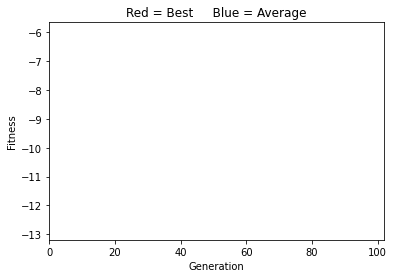

In [297]:
ma=Ma(nQ=20,popSize=100,maxGen=100,pCross=0.98,pMut=0,maxLocalSearch=5,pLocalSearch=0,tSize=3)
ma.MemeticAlgorithm()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,9,5,2,16,17,3,12,8,19,14,6,13,7,15,11,4,10,0,18,1
1,15,12,4,14,8,2,5,0,17,1,16,19,18,11,10,7,13,6,3,9
2,10,4,11,8,6,14,18,5,0,17,2,15,3,9,7,13,16,1,12,19
3,16,2,19,11,3,9,5,13,0,18,7,17,12,1,15,6,10,8,4,14
4,9,6,2,14,19,15,8,18,3,12,4,17,0,16,5,10,1,7,11,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,10,12,1,18,3,15,17,8,19,5,2,16,7,6,13,14,11,9,4
96,9,0,6,4,15,19,1,14,7,17,13,18,16,8,11,10,5,12,3,2
97,16,15,19,2,12,7,14,13,4,5,6,1,11,17,3,18,0,8,9,10
98,10,6,18,15,14,17,8,5,16,13,0,3,2,11,12,7,1,9,4,19


,0
0,-6
1,-7
2,-7
3,-8
4,-8
...,...
95,-20
96,-22
97,-22
98,-22


-6 -12.94
-5 -10.23
-2 -8.89
------------------------------
-2


,0
0,5
1,12
2,11
3,9
4,16
5,2
6,10
7,15
8,1
9,19


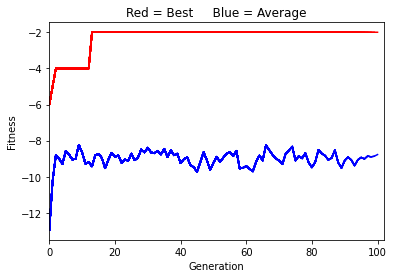

In [280]:
ma=Ma(nQ=20,popSize=100,maxGen=100,pCross=0.98,pMut=0,maxLocalSearch=10,pLocalSearch=0.5,tSize=2)
ma.MemeticAlgorithm()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,60,68,86,19,72,73,87,83,67,33,...,91,99,41,71,23,17,61,63,43,79
1,10,5,70,48,32,72,24,3,63,98,...,97,79,34,16,28,68,88,49,46,90
2,24,46,92,72,31,58,19,11,95,84,...,9,38,77,20,3,16,14,30,86,48
3,14,65,81,83,79,22,17,96,28,49,...,66,21,88,75,54,89,69,5,37,7
4,38,32,95,97,49,98,74,31,94,28,...,35,54,20,51,9,61,40,2,29,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,55,94,16,57,29,13,47,88,32,6,...,15,31,63,85,98,5,9,81,2,38
96,2,39,81,3,51,60,33,12,85,49,...,1,19,27,26,91,52,95,88,73,8
97,75,54,98,36,4,33,79,74,78,12,...,68,5,45,69,57,67,80,51,13,56
98,10,43,26,83,34,45,37,0,40,85,...,68,24,14,41,74,90,82,18,9,12


,0
0,-45
1,-49
2,-50
3,-51
4,-51
...,...
95,-83
96,-84
97,-85
98,-88


-45 -66.53
-45 -66.53
-35 -66.53
-35 -66.53
-35 -66.53


KeyboardInterrupt: 

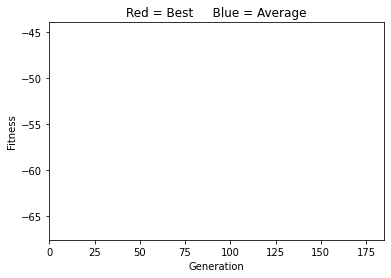

In [299]:
ma=Ma(nQ=100,popSize=100,maxGen=1000,pCross=0.95,pMut=0.05,maxLocalSearch=5,pLocalSearch=0.5,tSize=2)
ma.MemeticAlgorithm()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,87,58,28,85,59,48,31,67,81,74,...,14,19,16,23,34,37,15,33,54,40
1,51,81,30,68,15,95,72,88,4,93,...,38,34,21,69,92,36,85,39,60,67
2,63,67,48,91,39,44,88,6,87,93,...,46,22,73,57,69,76,75,95,20,5
3,0,58,11,84,63,5,81,42,86,33,...,9,20,62,17,29,23,53,28,56,78
4,62,97,2,24,43,3,20,65,70,92,...,5,67,73,12,99,14,4,36,98,31
5,19,4,35,12,80,63,81,33,66,76,...,25,93,89,42,99,73,5,55,61,59
6,42,9,35,54,76,6,23,38,26,60,...,1,17,98,89,49,85,59,48,68,72
7,45,11,18,10,0,90,13,44,54,99,...,79,68,96,8,82,86,1,39,3,19
8,99,40,79,67,14,0,87,39,18,29,...,64,5,57,23,9,74,22,6,98,48
9,7,54,39,38,22,59,51,50,53,96,...,42,28,0,27,5,29,55,41,91,82


,0
0,-50
1,-54
2,-63
3,-64
4,-65
5,-65
6,-65
7,-67
8,-67
9,-67


-50
-37
-34
-33
------------------------------
-32


,0
0,11
1,45
2,0
3,85
4,10
...,...
95,50
96,91
97,39
98,3


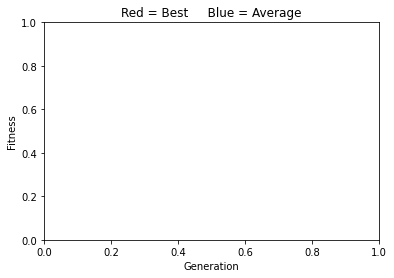

In [312]:
ma=Ma(nQ=100,popSize=20,maxGen=200,pCross=0,pMut=0,maxLocalSearch=5,pLocalSearch=0.5,tSize=2)
ma.MemeticAlgorithm()

In [ ]:
ma=Ma(nQ=100,popSize=20,maxGen=200,pCross=0.95,pMut=0.06,maxLocalSearch=100,pLocalSearch=0.5,tSize=3)
ma.MemeticAlgorithm()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,98,48,66,58,84,87,61,21,40,9,...,91,39,89,75,29,96,77,5,44,1
1,55,98,7,42,77,80,78,85,47,62,...,97,59,95,24,91,1,43,8,82,30
2,64,58,4,40,20,99,89,57,1,59,...,94,75,50,92,68,34,67,8,61,3
3,87,52,34,56,43,35,47,98,88,2,...,40,7,77,67,97,38,8,14,68,78
4,76,95,65,29,82,55,26,88,8,90,...,11,35,12,97,58,80,57,24,28,46
5,78,90,84,42,60,55,82,62,38,96,...,45,89,14,6,70,33,46,10,1,19
6,97,84,48,77,36,60,58,41,68,98,...,59,31,18,25,72,10,94,39,82,29
7,70,60,48,39,47,25,21,56,12,62,...,1,84,87,33,53,72,69,81,74,6
8,44,4,38,63,8,87,12,73,48,69,...,0,17,23,77,78,49,70,24,80,85
9,34,92,88,61,70,33,62,23,86,84,...,42,54,7,30,14,55,31,38,63,11


,0
0,-51
1,-57
2,-58
3,-59
4,-60
5,-62
6,-62
7,-63
8,-64
9,-65


-51 -65.05
-26 -52.45
-17 -34.55
-17 -40.85
